In [1]:
# be sure to have run ' python setup.py ' from chimp director

# Training DeepMind's Atari DQN with Chimp

Load Chimp modules

In [2]:
from chimp.memories import ReplayMemoryHDF5

from chimp.learners.dqn_learner import DQNLearner
from chimp.learners.chainer_backend import ChainerBackend

from chimp.simulators.atari import AtariSimulator

from chimp.agents import DQNAgent

Load Python packages

In [3]:
%matplotlib inline  
import matplotlib.pyplot as plt

import numpy as np
import random
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import Chain
import os

import pandas as ps

Set training parameters

In [4]:
settings = {

    # agent settings
    'batch_size' : 32,
    'print_every' : 5000,
    'save_dir' : './results_atari',
    'iterations' : 5000000,
    'eval_iterations' : 5000,
    'eval_every' : 50000,
    'save_every' : 50000,
    'initial_exploration' : 50000,
    'epsilon_decay' : 0.000005, # subtract from epsilon every step
    'eval_epsilon' : 0.05, # epsilon used in evaluation, 0 means no random actions
    'epsilon' : 1.0,  # Initial exploratoin rate
    'learn_freq' : 4,
    'history_sizes' : (4, 0, 0), # sizes of histories to use as nn inputs (o, a, r)
    'model_dims' : (84,84),
    
    # Atari settings
    'rom' : "Breakout.bin",
    'rom_dir' :  './roms',
    'pad' : 15, # padding parameter - for image cropping - only along the length of the image, to obtain a square
    'action_history' : True,

    # simulator settings
    'viz' : True,
    'viz_cropped' : False,

    # replay memory settings
    'memory_size' : 1000000,  # size of replay memory
    'frame_skip' : 4,  # number of frames to skip

    # learner settings
    'learning_rate' : 0.00025, 
    'decay_rate' : 0.95, # decay rate for RMSprop, otherwise not used
    'discount' : 0.99, # discount rate for RL
    'clip_err' : False, # value to clip loss gradients to
    'clip_reward' : 1, # value to clip reward values to
    'target_net_update' : 10000, # update the update-generating target net every fixed number of iterations
    'optim_name' : 'RMSprop', # currently supports "RMSprop", "ADADELTA", "ADAM" and "SGD"'
    'gpu' : True,
    'reward_rescale': False,

    # general
    'seed_general' : 1723,
    'seed_simulator' : 5632,
    'seed_agent' : 9826,
    'seed_memory' : 7563

    }

You may want to set a smaller number of iterations (like 100000) - for illustration purposes. We set the GPU option to True, turn it off if your machine does not support it. Be sure to have the requested rom in the indicated directory.

In [5]:
# set random seed
np.random.seed(settings["seed_general"])
random.seed(settings["seed_general"])

Now we initialize the simulator first, as we need to use some information it provides - e.g., number of actions.

In [6]:
simulator = AtariSimulator(settings)

Original screen width/height: 160/210
Cropped screen width/height: 84/84


Here we define the convolutional network, in a format required by Chainer - the deep learning library we use.

In [7]:
#Define the network
class Convolution(Chain):

    def __init__(self):
        super(Convolution, self).__init__(
            l1=F.Convolution2D(settings['history_sizes'][0], 32, ksize=8, stride=4, nobias=False, wscale=np.sqrt(2)),
            l2=F.Convolution2D(32, 64, ksize=4, stride=2, nobias=False, wscale=np.sqrt(2)),
            l3=F.Convolution2D(64, 64, ksize=3, stride=1, nobias=False, wscale=np.sqrt(2)),
            l4=F.Linear(3136, 512, wscale = np.sqrt(2)),
            l5=F.Linear(512, simulator.n_actions, wscale = np.sqrt(2)),
        )

    def __call__(self, ohist, ahist):
        if len(ohist.data.shape) < 4:
            ohist = F.reshape(ohist,(1,4,84,84))
        h1 = F.relu(self.l1(ohist/255.0))
        h2 = F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        h4 = F.relu(self.l4(h3))
        output = self.l5(h4)
        return output

net = Convolution()

We then initialize the learner + chainer backend, replay memory, and agent modules.

In [8]:
backend = ChainerBackend(settings)
backend.set_net(net)
learner = DQNLearner(settings, backend)

In [9]:
memory = ReplayMemoryHDF5(settings)

In [10]:
agent = DQNAgent(learner, memory, simulator, settings)

Now let the agent train.

In [ ]:
agent.train()

# Visualizing results

First, let's visualize the training and evaluation results.

In [11]:
train_stats = ps.read_csv('%s/training_history.csv' % settings['save_dir'],delimiter=' ',header=None)
train_stats.columns = ['Iteration','MSE Loss','Average Q-Value']

In [12]:
eval_stats = ps.read_csv('%s/evaluation_history.csv' % settings['save_dir'],delimiter=' ',header=None)
eval_stats.columns = ['Iteration','Total Reward','Reward per Episode']

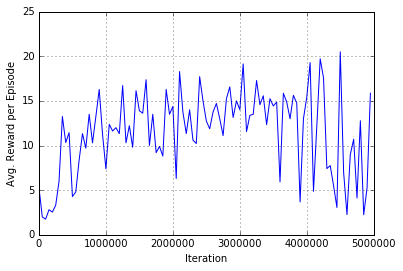

In [13]:
plt.plot(eval_stats['Iteration'], eval_stats['Reward per Episode'])
plt.xlabel("Iteration")
plt.ylabel("Avg. Reward per Episode")
plt.grid(True)
#plt.savefig(settings['save_dir'] + '_' + "evaluation_reward.svg", bbox_inches='tight')
plt.show()
plt.close()

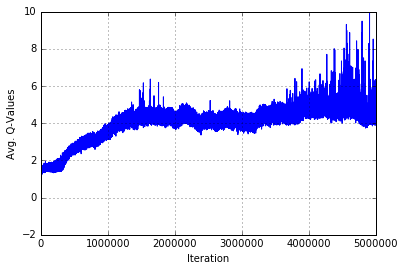

In [14]:
plt.plot(train_stats['Iteration'], train_stats['Average Q-Value'])
plt.xlabel("Iteration")
plt.ylabel("Avg. Q-Values")
plt.grid(True)
#plt.savefig(settings['save_dir'] + '_' + "training_q_values.svg", bbox_inches='tight')
plt.show()
plt.close()

# Evaluating the best policy

Let's load the network that collected the highest reward per game episode

In [15]:
best_iteration_index = np.argmax(eval_stats['Reward per Episode'])
best_iteration = str(int(eval_stats['Iteration'][best_iteration_index]))

In [16]:
best_iteration 

'4500000'

In [17]:
agent.learner.load_net(settings['save_dir']+'/net_' + best_iteration + '.p')

In [18]:
r_tot, r_per_episode, runtime = agent.simulate(10000, epsilon=0.05, viz=True)

In [19]:
r_per_episode

17.6